<a href="https://colab.research.google.com/github/Garanyan/made_nlp/blob/master/Garanyan_homework03_Neural_Machine_Translation_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.



1.   Learning rate, without positional encoding, pretrained model
2.   Learning rate, with positional encoding, pretrained model
3.   Learning rate, with positional encoding, attention



In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [0]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [0]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [0]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [0]:
SRC.build_vocab(train_data, min_freq = 4)
TRG.build_vocab(train_data, min_freq = 3)

In [9]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 7096
Unique tokens in target (en) vocabulary: 6710


Here are tokens from original (RU) corpus:

In [10]:
SRC.vocab.itos[::1000]

['<unk>',
 'сердце',
 '850',
 'курение',
 'centrum',
 'функциональном',
 'nana',
 'фира']

В русском корпусе есть английские слова, может их удалить?

And from target (EN) corpus:

In [11]:
TRG.vocab.itos[::900]

['<unk>',
 'organise',
 'beers',
 '20th',
 'sofitel',
 'dongguan',
 'carana',
 'rapids']

And here is example from train dataset:

In [12]:
print(vars(train_data.examples[0]))
print(vars(train_data.examples[8]))
print(vars(train_data.examples[20]))

{'trg': ['they', 'also', 'have', 'access', 'to', 'a', 'shared', 'bathroom', '.'], 'src': ['гости', 'могут', 'пользоваться', 'общей', 'ванной', 'комнатой', '.']}
{'trg': ['in', 'the', 'evenings', ',', 'enjoy', 'fine', 'wine', 'and', 'international', 'cocktails', 'at', 'blue', 'heaven', 'bar', '.'], 'src': ['по', 'вечерам', 'в', 'баре', 'blue', 'heaven', 'подают', 'вегетарианские', 'закуски', ',', 'изысканное', 'вино', ',', 'а', 'также', 'интернациональные', 'алкогольные', 'и', 'безалкогольные', 'коктейли', '.']}
{'trg': ['guests', 'can', 'also', 'enjoy', 'a', 'homemade', 'four', '-', 'course', 'meal', 'upon', 'request', ',', 'which', 'can', 'be', 'served', 'on', 'the', 'terrace', 'or', 'in', 'the', 'dining', 'room', '.'], 'src': ['по', 'запросу', 'гости', 'могут', 'заказать', '4', 'блюда', 'домашнего', 'приготовления', ',', 'которые', 'подаются', 'на', 'террасе', 'или', 'в', 'обеденном', 'зале', '.']}


Опять, не все слова переводятся, что делать с Названиями? и кавычками. 

In [13]:
with open(path_do_data) as tsvfile:
  for i in range(0,101):
    line = tsvfile.readline().split('\t')
    if i % 20 == 0:
      print(f"{i}. {line[0]}\n{line[1]}")

0. Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.
Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.

20. The spa offers massages with a view of the sea, a fitness room and aqua gym.
В спа-центре предлагается массаж с видом на море, а также можно посетить фитнес-зал и аквааэробику.

40. Apartments at La Ferula come with a flat-screen TV, kitchen and dining area.
Апартаменты комплекса La Ferula располагают телевизором с плоским экраном, кухней и обеденной зоной.

60. Palace Jasmine is 15 km from Trivandrum International Airport.
Отель Palace Jasmine находится в 15 км от международного аэропорта Тривандрума.

80. Alicante Airport can be reached by car in 1 hour.
Поездка до аэропорта Аликанте займет 1 час.

100. Each offers a spacious living room with a flat-screen TV, while the kitchen includes an oven, a stove and a fridge.
Все они располагают просторной гостиной с телевизором с плоским экраном, а также кухней с дух

Let's check the length distributions:

Length distribution in Train data


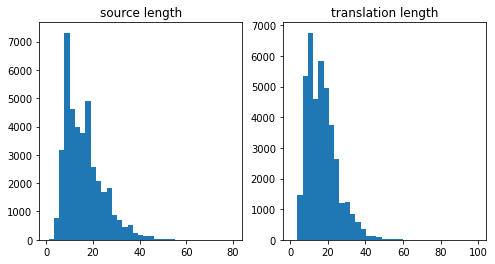

In [14]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=35);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=35);

Length distribution in Test data


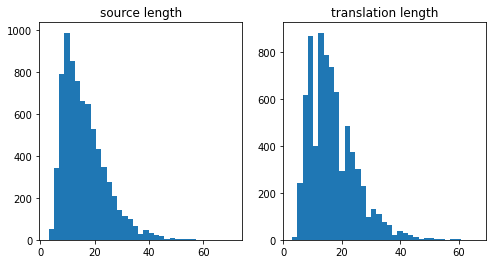

In [15]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=35);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=35);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda')

In [0]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [19]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 64]
	[.trg]:[torch.cuda.LongTensor of size 37x64 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 42x64 (GPU 0)]
torch.Size([42, 64]) torch.Size([37, 64])


In [0]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq
Attention = my_network.Attention

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, ENC_DROPOUT)
atten = Attention(ENC_HID_DIM, DEC_HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, atten)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7096, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
    )
    (embedding): Embedding(6710, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=6710, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,998,646 trainable parameters


In [0]:
PAD_IDX = TRG.vocab.stoi['<pad>']
lr = 0.05
optimizer = optim.Adam(model.parameters())
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel(f'Batch {i}')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch ' + str(len(valid_history)))
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

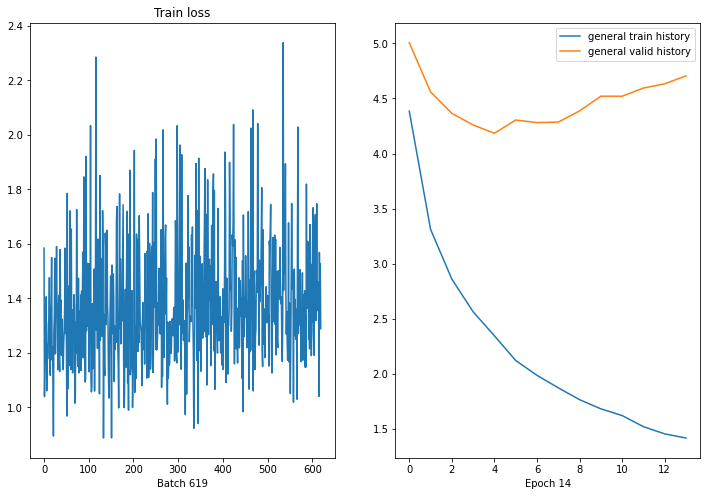

Epoch: 15 | Time: 9m 37s
	Train Loss: 1.376 | Train PPL:   3.958
	 Val. Loss: 4.708 |  Val. PPL: 110.826


In [29]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'gru-attention-model.pt')

    #scheduler.step(valid_loss)
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if math.isnan(train_loss) or math.isnan(valid_loss):
      break

In [46]:
model.load_state_dict(torch.load('gru-attention-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.162 | Test PPL:  64.192 |


__Let's take a look at our network quality__:

In [0]:
#del utils

In [0]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [0]:
batch = next(iter(test_iterator))

In [33]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Shape of src: torch.Size([7, 1])
Shape of trg: torch.Size([14, 1])
Shape of output: torch.Size([14, 1, 6710])
Original: a tv is available .
Generated: a tv is provided .

Shape of src: torch.Size([7, 1])
Shape of trg: torch.Size([14, 1])
Shape of output: torch.Size([14, 1, 6710])
Original: you will find a coffee machine in the room .
Generated: you will find a coffee machine in the room .



In [0]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [0]:
import tqdm

In [49]:
input_text = []
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        input_text.extend([get_text(x, SRC.vocab) for x in src.cpu().numpy().T])
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
        if len(original_text) != len(generated_text):
          print(f"Len broken {i}")

#input_text = flatten(input_text)
#original_text = flatten(original_text)
#generated_text = flatten(generated_text)

118it [00:15,  7.49it/s]


In [50]:
# GRU with attention, После 4 эпохи val loss начал расти, а train loss продолжал падать
# Долго обучалось, 15 эпох, 1 эпоха наверное минут 20. Так и должно быть тк attention дорогая операция.
# Seq2Seq(
#  (encoder): Encoder(
#    (embedding): Embedding(7096, 256)
#    (rnn): GRU(256, 512, bidirectional=True)
#    (fc): Linear(in_features=1024, out_features=512, bias=True)
#    (dropout): Dropout(p=0.5, inplace=False)
#  )
#  (decoder): Decoder(
#    (attention): Attention(
#      (attn): Linear(in_features=1536, out_features=512, bias=True)
#    )
#    (embedding): Embedding(6710, 256)
#    (rnn): GRU(1280, 512)
#    (out): Linear(in_features=1792, out_features=6710, bias=True)
#    (dropout): Dropout(p=0.5, inplace=False)
#  )
#)
# Best model 
# | Test Loss: 4.162 | Test PPL:  64.192 |
# 28.830881745658843
corpus_bleu([[text] for text in original_text], generated_text) * 100

28.830881745658843

In [0]:
# baseline 17.15361805033738
# corpus_bleu([[text] for text in original_text], generated_text) * 100

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points